In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [3]:
import os

# Create folders in Colab's local storage
os.makedirs('/content/LYA', exist_ok=True)
os.makedirs('/content/LYT', exist_ok=True)

# Copy from Google Drive (replace with your actual paths!)
!cp /content/drive/MyDrive/LYA-Augmented/* /content/LYA/
!cp /content/drive/MyDrive/LYT/* /content/LYT/


In [4]:
from PIL import Image
import numpy as np

def load_images_pil(folder, label, size=(128, 128), limit=None):
    images, labels = [], []
    filenames = os.listdir(folder)

    for idx, filename in enumerate(filenames):
        if limit and idx >= limit:
            break
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L').resize(size)
            images.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue
    return np.array(images), np.array(labels)


In [5]:
# Load balanced data from local Colab storage
lya_dir = '/content/LYA'
lyt_dir = '/content/LYT'

# Use the optimized PIL loader
lya_images, lya_labels = load_images_pil(lya_dir, label=1, limit=450)
lyt_images, lyt_labels = load_images_pil(lyt_dir, label=0, limit=450)

# Combine datasets
X = np.concatenate((lya_images, lyt_images), axis=0)
y = np.concatenate((lya_labels, lyt_labels), axis=0)

# Normalize & reshape
X = X / 255.0
X = X.reshape(-1, 128, 128, 1)

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 2)


In [6]:
eda_data = []

for i in range(len(X)):
    img = X[i].reshape(128, 128)
    mean_val = np.mean(img)
    std_val = np.std(img)
    psnr_val = psnr(np.ones_like(img), img)
    ssim_val = ssim(np.ones_like(img), img, data_range=1.0)
    label = int(np.argmax(y[i]))
    eda_data.append([i, mean_val, std_val, psnr_val, ssim_val, label])

eda_df = pd.DataFrame(eda_data, columns=["Index", "Mean", "STD", "PSNR", "SSIM", "Label"])
eda_df.to_csv('/content/drive/MyDrive/eda_results.csv', index=False)

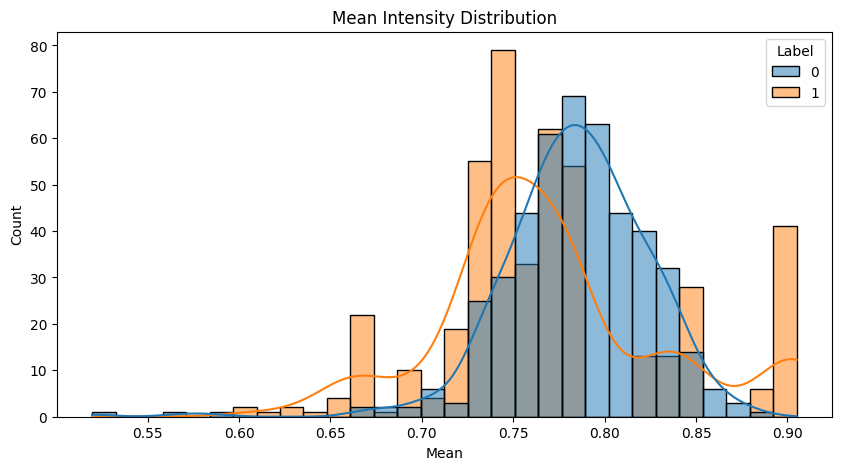

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mean distribution plot
plt.figure(figsize=(10,5))
sns.histplot(eda_df, x="Mean", hue="Label", kde=True, bins=30)
plt.title("Mean Intensity Distribution")
plt.savefig('/content/drive/MyDrive/eda_mean_distribution.png')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 630 Val: 90 Test: 180


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save history as CSV
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.5702 - loss: 0.8347 - val_accuracy: 0.8333 - val_loss: 0.5679
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7986 - loss: 0.5031 - val_accuracy: 0.8556 - val_loss: 0.4274
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8444 - loss: 0.3532 - val_accuracy: 0.7889 - val_loss: 0.4209
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8793 - loss: 0.3026 - val_accuracy: 0.8667 - val_loss: 0.3489
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9244 - loss: 0.2259 - val_accuracy: 0.7778 - val_loss: 0.4879
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9125 - loss: 0.2304 - val_accuracy: 0.8667 - val_loss: 0.3584
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9321 - loss: 0.1548 - val_accuracy: 0.8778 - val_loss: 0.2768
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9712 - loss: 0.1053 - val_accuracy: 0.9000 - 

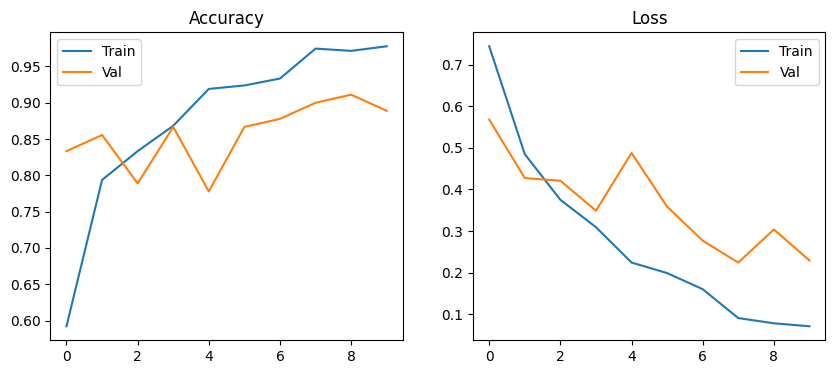

In [11]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/training_curves.png')
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


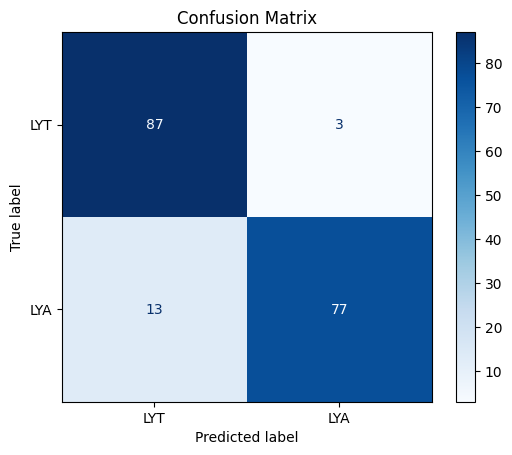

              precision    recall  f1-score   support

         LYT       0.87      0.97      0.92        90
         LYA       0.96      0.86      0.91        90

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.92      0.91      0.91       180



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LYT", "LYA"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=["LYT", "LYA"])
print(report)

# Save classification report
with open('/content/drive/MyDrive/classification_report.txt', 'w') as f:
    f.write(report)


In [13]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path).convert('L').resize(size)
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 1)
    return img_array


In [14]:
# Path to a new image
test_path = '/content/drive/MyDrive/LYT test/LYT_0001.tiff'

# Preprocess
test_img = preprocess_image(test_path)

# Predict
prediction = model.predict(test_img)
pred_class = np.argmax(prediction)

# Decode label
label_map = {0: 'LYT', 1: 'LYA'}
print("Predicted class:", label_map[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Predicted class: LYT


In [15]:
def predict_folder(folder_path):
    results = []
    for fname in os.listdir(folder_path):
        try:
            fpath = os.path.join(folder_path, fname)
            img = preprocess_image(fpath)
            pred = model.predict(img)
            label = np.argmax(pred)
            label_name = label_map[label]
            results.append([fname, label_name, float(pred[0][label])])
        except Exception as e:
            print(f"Skipping {fname}: {e}")
    return results

# Example: Predict all images in /content/drive/MyDrive/TestSamples
predictions = predict_folder('/content/drive/MyDrive/LYT test')

# Save as CSV
pred_df = pd.DataFrame(predictions, columns=["Image", "Predicted_Label", "Confidence"])
pred_df.to_csv('/content/drive/MyDrive/predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


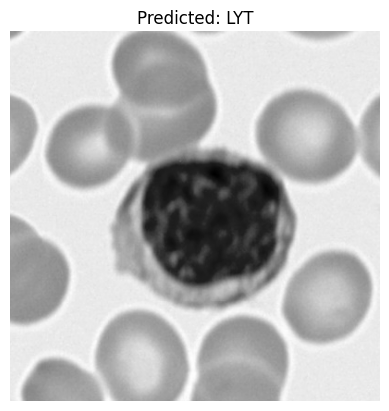

In [16]:
import matplotlib.pyplot as plt

img = Image.open(test_path).convert('L')
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {label_map[pred_class]}")
plt.axis('off')
plt.show()


In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

label_map = {0: 'LYT', 1: 'LYA'}

def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path).convert('L').resize(size)
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 1)
    return img_array, img

def predict_and_display_folder(folder_path, show_images=True, save_csv=True):
    results = []

    for fname in os.listdir(folder_path):
        try:
            fpath = os.path.join(folder_path, fname)
            img_array, img_display = preprocess_image(fpath)

            pred = model.predict(img_array)
            pred_class = np.argmax(pred)
            confidence = float(pred[0][pred_class])
            label_name = label_map[pred_class]

            # Add to results
            results.append([fname, label_name, confidence])

            # Show image + prediction
            if show_images:
                plt.imshow(img_display, cmap='gray')
                plt.title(f"Predicted: {label_name} ({confidence:.2f})")
                plt.axis('off')
                plt.show()

        except Exception as e:
            print(f"Skipping {fname}: {e}")

    # Save to CSV
    if save_csv:
        pred_df = pd.DataFrame(results, columns=["Image", "Predicted_Label", "Confidence"])
        pred_df.to_csv('/content/drive/MyDrive/predictions.csv', index=False)
        print("📁 Saved predictions to Google Drive.")

    return results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


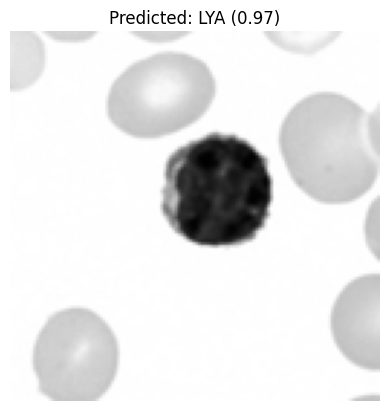

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


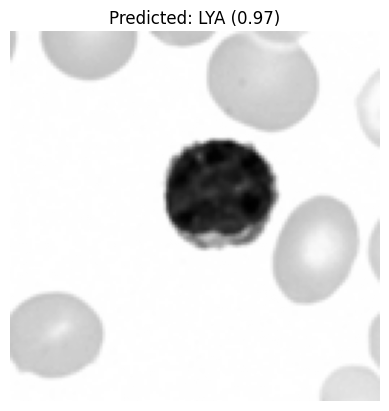

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


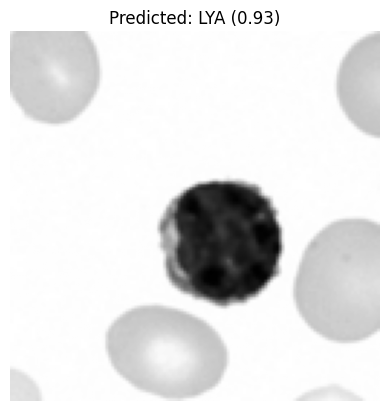

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


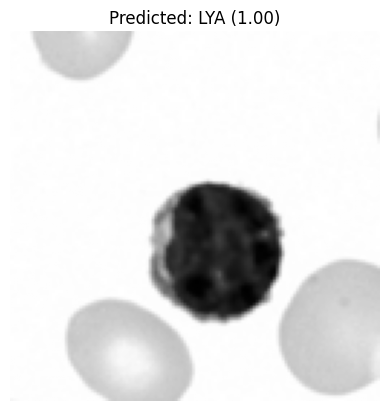

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


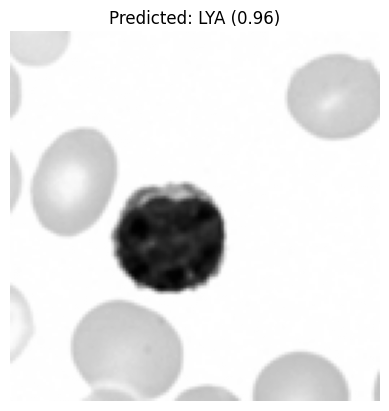

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


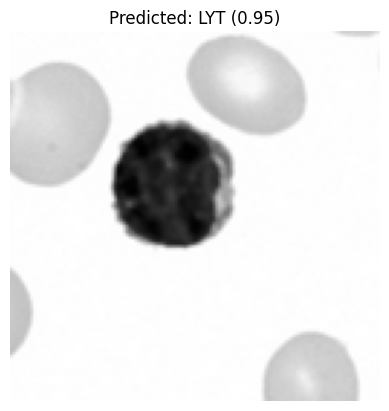

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


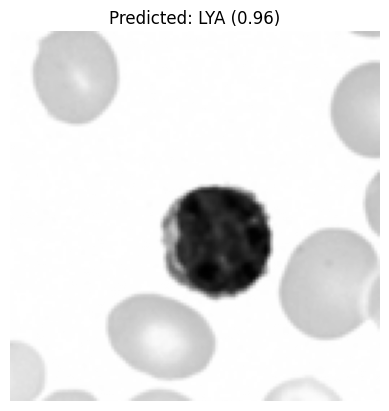

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


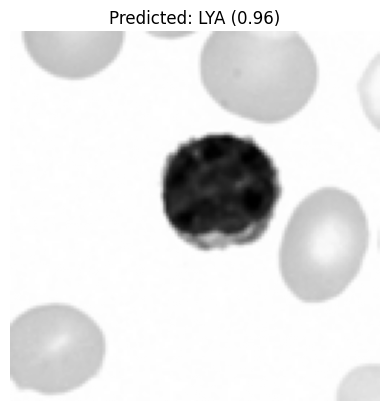

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


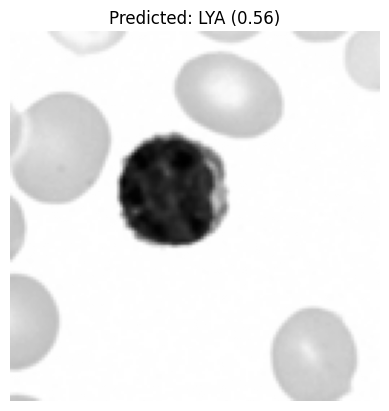

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


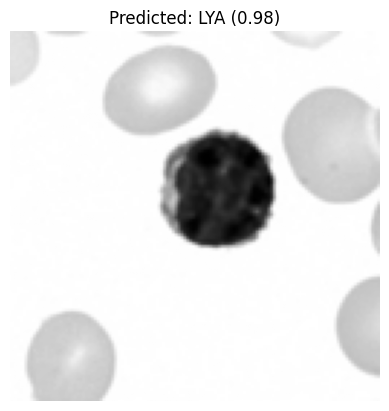

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


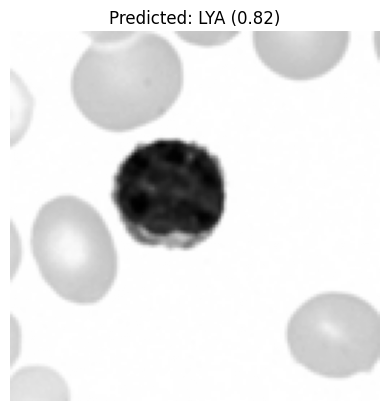

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


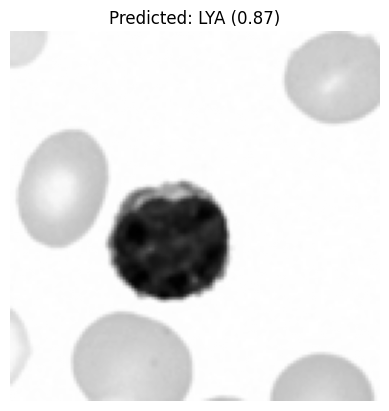

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


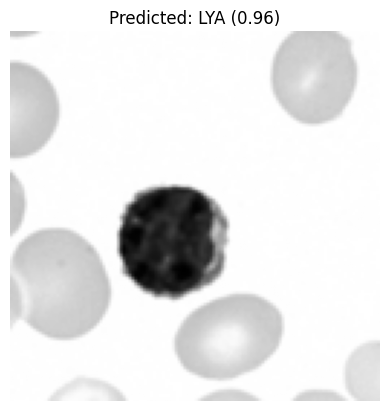

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


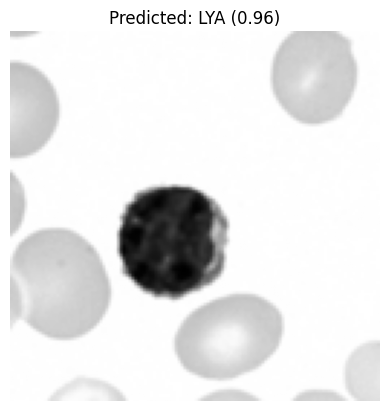

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


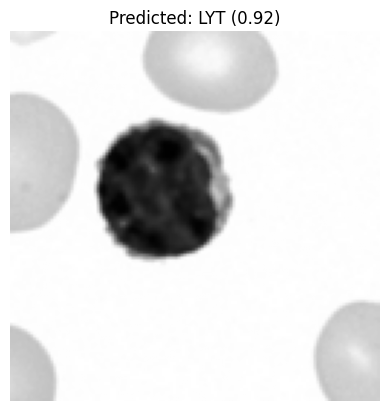

📁 Saved predictions to Google Drive.


In [19]:
# Replace with your folder of test images
test_folder = '/content/drive/MyDrive/LYA test'

# Run batch prediction + image display
predictions = predict_and_display_folder(test_folder)
